In [42]:
root =  "/home/brainmappinglab/Desktop/PROJECTS/Glioblastoma-TractDensity_Surival-Prognosis" # "D:\JoanFR_Sano"
MNI_DIR = "/home/brainmappinglab/Desktop/PROJECTS/MNI_ICBM_2009b_NLIN_ASYM" # "C:/Users/user/Documents/Data/MNI"
fmt = "svg"
dpi = 300
stream_th = 0

In [43]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pylab as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from tqdm import tqdm
import nibabel as nib
import nilearn.plotting as plotting

from scipy.stats import pearsonr, ttest_ind, mannwhitneyu, zscore, sem, f_oneway, chi2

import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import fdrcorrection
from statsmodels.duration.hazard_regression import PHReg

from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.compare import compare_survival
from sksurv.preprocessing import OneHotEncoder
from sksurv.column import categorical_to_numeric
from sksurv.linear_model import CoxPHSurvivalAnalysis

from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    GridSearchCV, KFold, RepeatedKFold, RepeatedStratifiedKFold,
    cross_val_score, cross_validate, cross_val_predict, permutation_test_score
)

import statsmodels.formula.api as smf

In [44]:
figs_folder = os.path.join(root,"Relationships-features_anatomy-morphology","UPENN")
daysXmonth = 365/12
voxel_size = (0.5**3) * (1/1000) # 0.5 (mm³/voxel) X 0.001 (cm³/mm³)   

os.makedirs(figs_folder, exist_ok=True) 

# Data

In [45]:
root_upenn = os.path.join(root,"Glioblastoma_UPENN-GBM_v2-20221024")
TDstats_upenn = pd.read_csv(os.path.join(root_upenn, f"TDMaps_IDH1-WT/demographics-TDMaps_streamTH-{stream_th}.csv"))
morphology_upenn = pd.read_csv(os.path.join(root_upenn, f"TDMaps_IDH1-WT/morphology-tissues.csv"))
    
common_cols = ["ID", "Gender", "Age_at_scan_years", "Survival_from_surgery_days_UPDATED", "Survival_Status", "MGMT", "KPS", "GTR_over90percent"]
upenn = pd.merge(TDstats_upenn, morphology_upenn, on=common_cols)

print(upenn["Survival_Status"].value_counts().sum())
censored = (upenn["Survival_Status"]==0).sum()
all_upenn = upenn["Survival_Status"].value_counts().sum()
print(f"Precentage of censoring: {round(100*censored/all_upenn,2)}%")

496
Precentage of censoring: 2.82%


In [46]:
z_transform = 0

mgmt_upenn = {"Unmethylated": 1, "Indeterminate": 2, "Methylated": 3, "Not Available": np.nan}
EOR_upenn = {"N": 1, "Y": 2, "Not Available": np.nan} # Since the "biopsy" category does not exist, we change the categorical encoding

# UCSF
DATA = pd.DataFrame({
    "ID": upenn["ID"].values,
    "male": [1 if s=="M" else 0 for s in upenn["Gender"].values],
    "female": [1 if s=="F" else 0 for s in upenn["Gender"].values],
    "sex": [1 if s=="M" else 2 for s in upenn["Gender"].values],
    "age": upenn["Age_at_scan_years"].values,
    "site": np.ones(len(upenn), dtype=int) + 1,  # UPENN = 2
    "volume": upenn["Whole tumor size (voxels)"].values * voxel_size,
    "ltdi": upenn["Whole lesion TDMap"].values,
    "tdi": upenn["Whole TDMap"].values,
    "OS": upenn["Survival_from_surgery_days_UPDATED"].values,
    "status": upenn["Survival_Status"].values,
    "EOR": [EOR_upenn[eor] for eor in upenn["GTR_over90percent"].values],
    "mgmt": [mgmt_upenn[mgmt] for mgmt in upenn["MGMT"].values],
    "KPS": [np.nan if kps=="Not Available" else int(kps) for kps in upenn["KPS"].values]
})

if z_transform == 1:
    for col in ["age", "volume", "ltdi", "tdi"]:
        DATA[col] = zscore(DATA[col])

In [47]:
# A very small subset of patients have a Karnofsky Performance Status score avaible...
DATA["KPS"].fillna(-1).value_counts()

KPS
-1.0      421
 90.0      37
 80.0      18
 60.0       6
 70.0       6
 100.0      5
 40.0       2
 30.0       1
Name: count, dtype: int64

# Tract density markers

### Including the volume (morphology)

In [48]:
covariates = ["ltdi","tdi","volume"]
data = DATA[covariates+["OS","status"]]

cox = PHReg(
    data["OS"],
    data[covariates],
    status=data["status"]
)
results_cox = cox.fit()
print(results_cox.summary(yname="Overall survival (days)", xname=covariates, title=f"Including the volume of the lesion (LLF={round(results_cox.llf,3)})"))

     Including the volume of the lesion (LLF=-2534.483)
Model:              PH Reg                  Sample size: 496
Dependent variable: Overall survival (days) Num. events: 482
Ties:               Breslow                                 
------------------------------------------------------------
        log HR log HR SE   HR      t    P>|t|  [0.025 0.975]
------------------------------------------------------------
ltdi    0.3191    0.0723 1.3759  4.4126 0.0000 1.1941 1.5854
tdi    -0.0017    0.0017 0.9983 -1.0267 0.3046 0.9950 1.0016
volume -0.0070    0.0017 0.9931 -4.0368 0.0001 0.9897 0.9964
Confidence intervals are for the hazard ratios


### Excluding the volume (morphology)

In [49]:
covariates = ["ltdi","tdi"]
data = DATA[covariates+["OS","status"]]

cox = PHReg(
    data["OS"],
    data[covariates],
    status=data["status"]
)
results_cox = cox.fit()
print(results_cox.summary(yname="Overall survival (days)", xname=covariates, title=f"Excluding the volume of the lesion (LLF={round(results_cox.llf,3)})"))

     Excluding the volume of the lesion (LLF=-2542.389)
Model:              PH Reg                  Sample size: 496
Dependent variable: Overall survival (days) Num. events: 482
Ties:               Breslow                                 
------------------------------------------------------------
         log HR log HR SE   HR     t    P>|t|  [0.025 0.975]
------------------------------------------------------------
ltdi     0.0453    0.0295 1.0463 1.5348 0.1248 0.9875 1.1087
tdi      0.0031    0.0012 1.0031 2.5592 0.0105 1.0007 1.0055
Confidence intervals are for the hazard ratios


### Equivalence between L-TDI and TDI + Volume

In [50]:
covariates = ["ltdi"]
data = DATA[covariates+["OS","status"]]

cox_ltdi = PHReg(
    data["OS"],
    data[covariates],
    status=data["status"]
)
results_ltdi = cox_ltdi.fit()
print(results_ltdi.summary(yname="Overall survival (days)", xname=covariates, title=f"L-TDI model (LLF={round(results_ltdi.llf,3)})"))

LLF_LTDI = cox_ltdi.loglike(results_ltdi.params)

                L-TDI model (LLF=-2545.588)
Model:              PH Reg                  Sample size: 496
Dependent variable: Overall survival (days) Num. events: 482
Ties:               Breslow                                 
------------------------------------------------------------
         log HR log HR SE   HR     t    P>|t|  [0.025 0.975]
------------------------------------------------------------
ltdi     0.0784    0.0260 1.0816 3.0156 0.0026 1.0278 1.1382
Confidence intervals are for the hazard ratios


In [51]:
covariates = ["tdi","volume"]
data = DATA[covariates+["OS","status"]]

cox_tdi = PHReg(
    data["OS"],
    data[covariates],
    status=data["status"]
)
results_tdi = cox_tdi.fit()
print(results_tdi.summary(yname="Overall survival (days)", xname=covariates, title=f"TDI + volume model (LLF={round(results_tdi.llf,3)})"))

LLF_TDI = cox_tdi.loglike(results_tdi.params)

             TDI + volume model (LLF=-2543.553)
Model:              PH Reg                  Sample size: 496
Dependent variable: Overall survival (days) Num. events: 482
Ties:               Breslow                                 
------------------------------------------------------------
        log HR log HR SE   HR      t    P>|t|  [0.025 0.975]
------------------------------------------------------------
tdi     0.0039    0.0011 1.0039  3.6226 0.0003 1.0018 1.0060
volume -0.0001    0.0007 0.9999 -0.1166 0.9072 0.9986 1.0013
Confidence intervals are for the hazard ratios


In [52]:
print("In all the following results, the effect of site was removed!")
print()
print(f"Log-likelihood of the model with the L-TDI as a covariate: {LLF_LTDI}")
print(f"Log-likelihood of the model with the TDI as a covariate: {LLF_TDI}")
print()

DF = 1 # The full model contains 1 more parameter than the reduced model
chi2_TDI_better = - 2 * (LLF_LTDI - LLF_TDI)
chi2_LTDI_better = - 2 * (LLF_TDI - LLF_LTDI)
p_value_TDI_better = 1 - chi2.cdf(chi2_TDI_better, df=DF)
p_value_LTDI_better = 1 - chi2.cdf(chi2_LTDI_better, df=DF)

print(f"P-value supposing that the TDI-based model performs better: {p_value_TDI_better:.4f}")
print(f"P-value supposing that the LTDI-based model performs better: {p_value_LTDI_better:.4f}")

In all the following results, the effect of site was removed!

Log-likelihood of the model with the L-TDI as a covariate: -2545.588192886824
Log-likelihood of the model with the TDI as a covariate: -2543.552877515751

P-value supposing that the TDI-based model performs better: 0.0436
P-value supposing that the LTDI-based model performs better: 1.0000


# Cox proportional Hazard models

## Missing value strategy $\to$ drop NaNs

### One hot encoding for Sex

In [53]:
covariates = ["male", "female", "age", "mgmt","EOR"]
data = DATA[covariates+["OS","status"]].dropna()

cox_onehot = PHReg(
    data["OS"],
    data[covariates],
    status=data["status"]
)
results_onehot = cox_onehot.fit()
print(results_onehot.summary(yname="Overall survival (days)", xname=covariates, title=f"One Hot encoding for Sex (LLF = {round(results_onehot.llf,3)})"))

          One Hot encoding for Sex (LLF = -1161.419)
Model:               PH Reg                   Sample size:  262
Dependent variable:  Overall survival (days)  Num. events:  256
Ties:                Breslow                                   
---------------------------------------------------------------
        log HR  log HR SE     HR      t    P>|t|  [0.025 0.975]
---------------------------------------------------------------
male   -0.0304 5863328.6715 0.9701 -0.0000 1.0000 0.0000    inf
female  0.0306 5863328.6715 1.0310  0.0000 1.0000 0.0000    inf
age     0.0271       0.0063 1.0275  4.2878 0.0000 1.0148 1.0403
mgmt   -0.4671       0.0726 0.6268 -6.4340 0.0000 0.5437 0.7226
EOR    -0.3959       0.1309 0.6731 -3.0253 0.0025 0.5208 0.8699
Confidence intervals are for the hazard ratios


/home/brainmappinglab/anaconda3/envs/glioblastomas/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/brainmappinglab/anaconda3/envs/glioblastomas/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Categorical encoding for Sex including L-TDI as a covariate of interest

In [54]:
covariates = ["sex", "age", "ltdi", "mgmt","EOR"]
data = DATA[covariates+["OS","status"]].dropna()

cox_ltdi = PHReg(
    data["OS"],
    data[covariates],
    status=data["status"]
)
results_ltdi = cox_ltdi.fit()
print(results_ltdi.summary(yname="Overall survival (days)", xname=covariates, title=f"L-TDI as covariate (LLF = {round(results_ltdi.llf,3)})"))

LLF_with_LTDI = cox_ltdi.loglike(results_ltdi.params)

            L-TDI as covariate (LLF = -1158.979)
Model:              PH Reg                  Sample size: 262
Dependent variable: Overall survival (days) Num. events: 256
Ties:               Breslow                                 
------------------------------------------------------------
        log HR log HR SE   HR      t    P>|t|  [0.025 0.975]
------------------------------------------------------------
sex     0.0491    0.1306 1.0503  0.3759 0.7070 0.8131 1.3567
age     0.0270    0.0064 1.0274  4.2348 0.0000 1.0146 1.0403
ltdi    0.0796    0.0361 1.0828  2.2050 0.0275 1.0089 1.1622
mgmt   -0.4674    0.0723 0.6266 -6.4686 0.0000 0.5439 0.7220
EOR    -0.3484    0.1318 0.7058 -2.6436 0.0082 0.5451 0.9138
Confidence intervals are for the hazard ratios


### Categorical encoding for Sex including TDI as a covariate of interest

In [55]:
covariates = ["sex", "age", "tdi", "mgmt","EOR"]
data = DATA[covariates+["OS","status"]].dropna()

cox_tdi = PHReg(
    data["OS"],
    data[covariates],
    status=data["status"]
)
results_tdi = cox_tdi.fit()
print(results_tdi.summary(yname="Overall survival (days)", xname=covariates, title=f"TDI as covariate (LLF = {round(results_tdi.llf,3)})"))

LLF_with_TDI = cox_tdi.loglike(results_tdi.params)

             TDI as covariate (LLF = -1158.061)
Model:              PH Reg                  Sample size: 262
Dependent variable: Overall survival (days) Num. events: 256
Ties:               Breslow                                 
------------------------------------------------------------
        log HR log HR SE   HR      t    P>|t|  [0.025 0.975]
------------------------------------------------------------
sex     0.0817    0.1314 1.0851  0.6216 0.5342 0.8387 1.4039
age     0.0255    0.0064 1.0259  3.9955 0.0001 1.0131 1.0388
tdi     0.0041    0.0016 1.0041  2.5566 0.0106 1.0009 1.0072
mgmt   -0.4674    0.0723 0.6266 -6.4642 0.0000 0.5438 0.7220
EOR    -0.3488    0.1323 0.7056 -2.6368 0.0084 0.5444 0.9144
Confidence intervals are for the hazard ratios


### Categorical encoding for Sex including TDI and volume as covariates of interest

In [56]:
covariates = ["sex", "age", "tdi", "volume", "mgmt","EOR"]
data = DATA[covariates+["OS","status"]].dropna()

cox_tdi_volume = PHReg(
    data["OS"],
    data[covariates],
    status=data["status"]
)
results_tdi_volume = cox_tdi_volume.fit()
print(results_tdi_volume.summary(yname="Overall survival (days)", xname=covariates, title=f"TDI as covariate (LLF = {round(results_tdi_volume.llf,3)})"))

LLF_with_TDI_volume = cox_tdi_volume.loglike(results_tdi_volume.params)

             TDI as covariate (LLF = -1157.972)
Model:              PH Reg                  Sample size: 262
Dependent variable: Overall survival (days) Num. events: 256
Ties:               Breslow                                 
------------------------------------------------------------
        log HR log HR SE   HR      t    P>|t|  [0.025 0.975]
------------------------------------------------------------
sex     0.0799    0.1314 1.0831  0.6077 0.5434 0.8372 1.4013
age     0.0256    0.0064 1.0260  4.0017 0.0001 1.0132 1.0389
tdi     0.0040    0.0016 1.0040  2.4931 0.0127 1.0009 1.0072
volume  0.0004    0.0010 1.0004  0.4221 0.6729 0.9985 1.0024
mgmt   -0.4669    0.0722 0.6269 -6.4628 0.0000 0.5441 0.7223
EOR    -0.3479    0.1321 0.7062 -2.6333 0.0085 0.5451 0.9149
Confidence intervals are for the hazard ratios


### Categorical encoding for Sex excluding tract density-based markers as covariates of interest

In [57]:
covariates = ["sex", "age", "mgmt","EOR"]
data = DATA[covariates+["OS","status"]].dropna()

cox = PHReg(
    data["OS"],
    data[covariates],
    status=data["status"]
)
results = cox.fit()
print(results.summary(yname="Overall survival (days)", xname=covariates, title=f"Without tract-based covariates (LLF = {round(results.llf,3)})"))

LLF_without_tracts = cox.loglike(results.params)

      Without tract-based covariates (LLF = -1161.419)
Model:              PH Reg                  Sample size: 262
Dependent variable: Overall survival (days) Num. events: 256
Ties:               Breslow                                 
------------------------------------------------------------
        log HR log HR SE   HR      t    P>|t|  [0.025 0.975]
------------------------------------------------------------
sex     0.0610    0.1309 1.0629  0.4659 0.6413 0.8224 1.3737
age     0.0271    0.0063 1.0275  4.2878 0.0000 1.0148 1.0403
mgmt   -0.4671    0.0726 0.6268 -6.4340 0.0000 0.5437 0.7226
EOR    -0.3959    0.1309 0.6731 -3.0253 0.0025 0.5208 0.8699
Confidence intervals are for the hazard ratios


### Comparing log-likelihoods

In [58]:
print(f"Log-likelihood of the model with the L-TDI as a covariate: {LLF_with_LTDI}")
print(f"Log-likelihood of the model with the TDI as a covariate: {LLF_with_TDI}")
print(f"Log-likelihood of the model with the TDI and volume as covariates: {LLF_with_TDI_volume}")
print(f"Log-likelihood of the model without tract density-based markers as covariates: {LLF_without_tracts}")
print()

DF = 1 # The full model contains 1 more parameter than the reduced model
chi2_LTDI = - 2 * (LLF_without_tracts - LLF_with_LTDI)
chi2_TDI = - 2 * (LLF_without_tracts - LLF_with_TDI)
chi2_TDI_volume = - 2 * (LLF_without_tracts - LLF_with_TDI_volume)
chi2_TDI_better = - 2 * (LLF_with_LTDI - LLF_with_TDI)
chi2_LTDI_better = - 2 * (LLF_with_TDI - LLF_with_LTDI)
chi2_LTDI_better_volume = - 2 * (LLF_with_TDI_volume - LLF_with_LTDI)

p_value_LTDI = 1 - chi2.cdf(chi2_LTDI, df=DF)
p_value_TDI = 1 - chi2.cdf(chi2_TDI, df=DF)
p_value_TDI_volume = 1 - chi2.cdf(chi2_TDI_volume, df=DF)
p_value_TDI_better = 1 - chi2.cdf(chi2_TDI_better, df=DF)
p_value_LTDI_better = 1 - chi2.cdf(chi2_LTDI_better, df=DF)
p_value_LTDI_better_volume = 1 - chi2.cdf(chi2_LTDI_better_volume, df=DF)

print(f"P-value associated with the addition of the L-TDI covariate: {p_value_LTDI:.4f}")
print(f"P-value associated with the addition of the TDI covariate: {p_value_TDI:.4f}")
print(f"P-value associated with the addition of the TDI and volume covariates: {p_value_TDI_volume:.4f}")
print(f"P-value supposing that the TDI-based model performs better: {p_value_TDI_better:.4f}")
print(f"P-value supposing that the LTDI-based model performs better: {p_value_LTDI_better:.4f}")
print(f"P-value supposing that the LTDI-based model performs better than the TDI and volume: {p_value_LTDI_better_volume:.4f}")

Log-likelihood of the model with the L-TDI as a covariate: -1158.9792729647006
Log-likelihood of the model with the TDI as a covariate: -1158.060655343465
Log-likelihood of the model with the TDI and volume as covariates: -1157.9720492441961
Log-likelihood of the model without tract density-based markers as covariates: -1161.4189231183288

P-value associated with the addition of the L-TDI covariate: 0.0272
P-value associated with the addition of the TDI covariate: 0.0096
P-value associated with the addition of the TDI and volume covariates: 0.0086
P-value supposing that the TDI-based model performs better: 0.1753
P-value supposing that the LTDI-based model performs better: 1.0000
P-value supposing that the LTDI-based model performs better than the TDI and volume: 1.0000


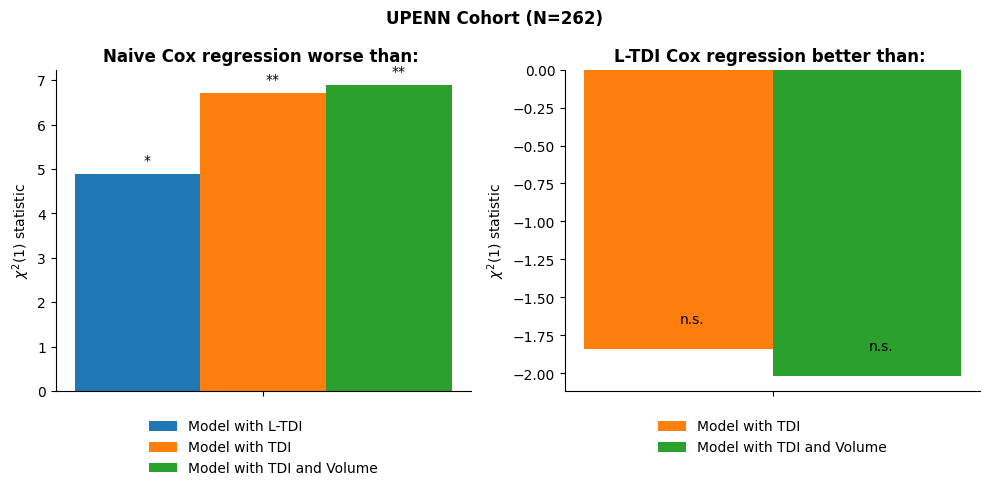

In [59]:
def get_significance_marker(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"  
    elif p < 0.05:
        return "*"  
    else:
        return "n.s." 
    
fig, ax = plt.subplots(1,2,figsize=(10, 5))
bar_width = 0.2
time_labels = [""]
x = np.arange(len(time_labels))

### Measuring the added value of tract density-based covariates
model_labels = ["Model with L-TDI", "Model with TDI", "Model with TDI and Volume"]
colors = ["tab:blue", "tab:orange", "tab:green"]
llrs = np.array([
    [chi2_LTDI, chi2_TDI, chi2_TDI_volume]
])
p_values = 1 - chi2.cdf(llrs, df=1)
for i in range(len(model_labels)):
    bars = ax[0].bar(x + i * bar_width, llrs[:, i], width=bar_width, label=model_labels[i], color=colors[i])
    for j, bar in enumerate(bars):
        height = bar.get_height()
        significance = get_significance_marker(p_values[j, i])
        ax[0].text(
            bar.get_x() + bar.get_width() / 2 + 0.015,
            height + 0.15, 
            significance,
            ha="center", va="bottom", fontsize=10
        )
ax[0].spines[["top","right"]].set_visible(False)
ax[0].set_xticks(x + bar_width, time_labels)
ax[0].set_ylabel(r'$\chi^2(1)$'+" statistic")
ax[0].legend(frameon=False, loc="upper center", bbox_to_anchor=(0.5, -0.05))
ax[0].set_title("Naive Cox regression worse than: ", fontweight='bold', fontsize=12)

### L-TDI against the other two models
model_labels = ["Model with TDI", "Model with TDI and Volume"]
colors = ["tab:orange", "tab:green"]
llrs = np.array([
    [chi2_LTDI_better, chi2_LTDI_better_volume]
])
p_values = 1 - chi2.cdf(llrs, df=1)
for i in range(len(model_labels)):
    bars = ax[1].bar(x + i * bar_width, llrs[:, i], width=bar_width, label=model_labels[i], color=colors[i])
    for j, bar in enumerate(bars):
        height = bar.get_height()
        significance = get_significance_marker(p_values[j, i])
        ax[1].text(
            bar.get_x() + bar.get_width() / 2 + 0.015,  
            height + 0.15,  
            significance,
            ha="center", va="bottom", fontsize=10
        )
ax[1].spines[["top","right"]].set_visible(False)
ax[1].set_xticks(x + bar_width/2, time_labels)
ax[1].set_ylabel(r'$\chi^2(1)$'+" statistic")
ax[1].legend(frameon=False, loc="upper center", bbox_to_anchor=(0.5, -0.05))
ax[1].set_title("L-TDI Cox regression better than: ", fontweight='bold', fontsize=12)

fig.suptitle(f"UPENN Cohort (N={len(data)})", fontsize=12, fontweight='bold')
fig.tight_layout()
fig.savefig(os.path.join(figs_folder, f"Cox-regression.{fmt}"), dpi=dpi, format=fmt)

### Including the Karnofsky Performance Status score 

A lot of patients have missing KPS scores. While this could be detrimental to the model and analyses, it's worth considering a model that includes all the available covariates. To proceed similarly as in the previous cases, we fit three different models and we compare them.

In [60]:
## L-TDI marker
covariates = ["sex", "age", "ltdi", "mgmt", "EOR", "KPS"]
data = DATA[covariates+["OS","status"]].dropna()
cox_ltdi = PHReg(
    data["OS"],
    data[covariates],
    status=data["status"]
)
results_ltdi = cox_ltdi.fit()
print(results_ltdi.summary(yname="Overall survival (days)", xname=covariates, title=f"L-TDI as covariate (LLF = {round(results_ltdi.llf,3)})"))
LLF_with_LTDI = cox_ltdi.loglike(results_ltdi.params)

## TDI marker
print()
covariates = ["sex", "age", "tdi", "mgmt", "EOR", "KPS"]
data = DATA[covariates+["OS","status"]].dropna()
cox_tdi = PHReg(
    data["OS"],
    data[covariates],
    status=data["status"]
)
results_tdi = cox_tdi.fit()
print(results_tdi.summary(yname="Overall survival (days)", xname=covariates, title=f"TDI as covariate (LLF = {round(results_tdi.llf,3)})"))
LLF_with_TDI = cox_tdi.loglike(results_tdi.params)

## TDI marker and volume
print()
covariates = ["sex", "age", "tdi", "volume", "mgmt", "EOR", "KPS"]
data = DATA[covariates+["OS","status"]].dropna()
cox_tdi_volume = PHReg(
    data["OS"],
    data[covariates],
    status=data["status"]
)
results_tdi_volume = cox_tdi_volume.fit()
print(results_tdi_volume.summary(yname="Overall survival (days)", xname=covariates, title=f"TDI and volume as covariates (LLF = {round(results_tdi_volume.llf,3)})"))
LLF_with_TDI_volume = cox_tdi_volume.loglike(results_tdi_volume.params)

## No tract density markers
print()
covariates = ["sex", "age", "mgmt", "EOR", "KPS"]
data = DATA[covariates+["OS","status"]].dropna()
cox = PHReg(
    data["OS"],
    data[covariates],
    status=data["status"]
)
results = cox.fit()
print(results.summary(yname="Overall survival (days)", xname=covariates, title=f"TDI as covariate (LLF = {round(results.llf,3)})"))
LLF_without_tracts = cox.loglike(results.params)


            L-TDI as covariate (LLF = -137.276)
Model:              PH Reg                  Sample size: 53
Dependent variable: Overall survival (days) Num. events: 53
Ties:               Breslow                                
-----------------------------------------------------------
       log HR log HR SE   HR      t    P>|t|  [0.025 0.975]
-----------------------------------------------------------
sex    0.1285    0.3077 1.1372  0.4177 0.6762 0.6222 2.0784
age    0.0605    0.0152 1.0624  3.9927 0.0001 1.0313 1.0944
ltdi   0.3015    0.1081 1.3519  2.7880 0.0053 1.0937 1.6710
mgmt  -1.0489    0.2167 0.3503 -4.8405 0.0000 0.2291 0.5357
EOR   -0.6170    0.3485 0.5396 -1.7707 0.0766 0.2725 1.0682
KPS   -0.0231    0.0122 0.9772 -1.8858 0.0593 0.9540 1.0009
Confidence intervals are for the hazard ratios

             TDI as covariate (LLF = -139.653)
Model:              PH Reg                  Sample size: 53
Dependent variable: Overall survival (days) Num. events: 53
Ties:            

In [61]:
print(f"Log-likelihood of the model with the L-TDI as a covariate: {LLF_with_LTDI}")
print(f"Log-likelihood of the model with the TDI as a covariate: {LLF_with_TDI}")
print(f"Log-likelihood of the model with the TDI and volume as covariates: {LLF_with_TDI_volume}")
print(f"Log-likelihood of the model without tract density-based markers as covariates: {LLF_without_tracts}")
print()

DF = 1 # The full model contains 1 more parameter than the reduced model
chi2_LTDI = - 2 * (LLF_without_tracts - LLF_with_LTDI)
chi2_TDI = - 2 * (LLF_without_tracts - LLF_with_TDI)
chi2_TDI_volume = - 2 * (LLF_without_tracts - LLF_with_TDI_volume)
chi2_TDI_better = - 2 * (LLF_with_LTDI - LLF_with_TDI)
chi2_LTDI_better = - 2 * (LLF_with_TDI - LLF_with_LTDI)
chi2_LTDI_better_volume = - 2 * (LLF_with_TDI_volume - LLF_with_LTDI)

p_value_LTDI = 1 - chi2.cdf(chi2_LTDI, df=DF)
p_value_TDI = 1 - chi2.cdf(chi2_TDI, df=DF)
p_value_TDI_better = 1 - chi2.cdf(chi2_TDI_better, df=DF)
p_value_LTDI_better = 1 - chi2.cdf(chi2_LTDI_better, df=DF)

print(f"P-value associated with the addition of the L-TDI covariate: {p_value_LTDI:.4f}")
print(f"P-value associated with the addition of the TDI covariate: {p_value_TDI:.4f}")
print(f"P-value associated with the addition of the TDI and volume covariates: {p_value_TDI_volume:.4f}")
print(f"P-value supposing that the TDI-based model performs better: {p_value_TDI_better:.4f}")
print(f"P-value supposing that the LTDI-based model performs better: {p_value_LTDI_better:.4f}")
print(f"P-value supposing that the LTDI-based model performs better than the TDI and volume: {p_value_LTDI_better_volume:.4f}")

Log-likelihood of the model with the L-TDI as a covariate: -137.27636793809296
Log-likelihood of the model with the TDI as a covariate: -139.65323108265028
Log-likelihood of the model with the TDI and volume as covariates: -139.17461339154704
Log-likelihood of the model without tract density-based markers as covariates: -141.22211590459258

P-value associated with the addition of the L-TDI covariate: 0.0050
P-value associated with the addition of the TDI covariate: 0.0765
P-value associated with the addition of the TDI and volume covariates: 0.0086
P-value supposing that the TDI-based model performs better: 1.0000
P-value supposing that the LTDI-based model performs better: 0.0292
P-value supposing that the LTDI-based model performs better than the TDI and volume: 1.0000


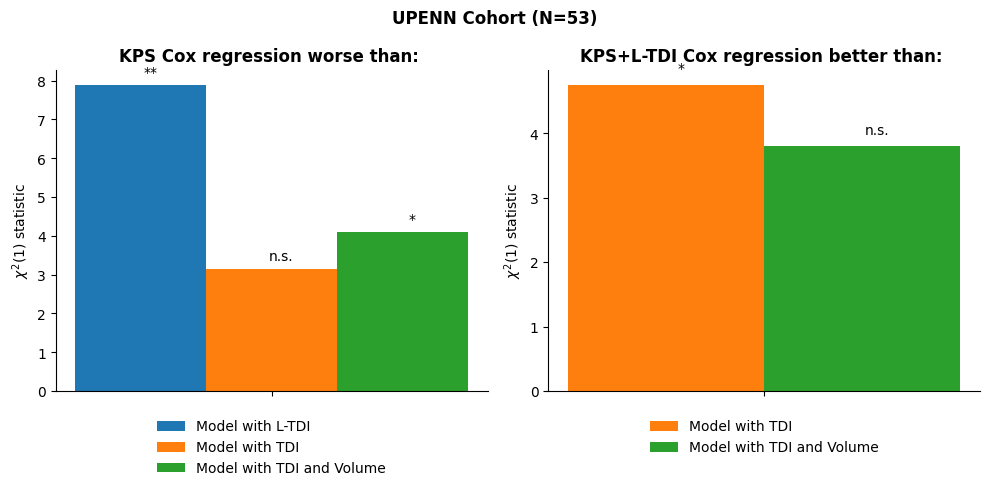

In [62]:
def get_significance_marker(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"  
    elif p < 0.05:
        return "*"  
    else:
        return "n.s." 
    
fig, ax = plt.subplots(1,2,figsize=(10, 5))
bar_width = 0.2
time_labels = [""]
x = np.arange(len(time_labels))

### Measuring the added value of tract density-based covariates
model_labels = ["Model with L-TDI", "Model with TDI", "Model with TDI and Volume"]
colors = ["tab:blue", "tab:orange", "tab:green"]
llrs = np.array([
    [chi2_LTDI, chi2_TDI, chi2_TDI_volume]
])
p_values = 1 - chi2.cdf(llrs, df=1)
for i in range(len(model_labels)):
    bars = ax[0].bar(x + i * bar_width, llrs[:, i], width=bar_width, label=model_labels[i], color=colors[i])
    for j, bar in enumerate(bars):
        height = bar.get_height()
        significance = get_significance_marker(p_values[j, i])
        ax[0].text(
            bar.get_x() + bar.get_width() / 2 + 0.015,
            height + 0.15, 
            significance,
            ha="center", va="bottom", fontsize=10
        )
ax[0].spines[["top","right"]].set_visible(False)
ax[0].set_xticks(x + bar_width, time_labels)
ax[0].set_ylabel(r'$\chi^2(1)$'+" statistic")
ax[0].legend(frameon=False, loc="upper center", bbox_to_anchor=(0.5, -0.05))
ax[0].set_title("KPS Cox regression worse than: ", fontweight='bold', fontsize=12)

### L-TDI against the other two models
model_labels = ["Model with TDI", "Model with TDI and Volume"]
colors = ["tab:orange", "tab:green"]
llrs = np.array([
    [chi2_LTDI_better, chi2_LTDI_better_volume]
])
p_values = 1 - chi2.cdf(llrs, df=1)
for i in range(len(model_labels)):
    bars = ax[1].bar(x + i * bar_width, llrs[:, i], width=bar_width, label=model_labels[i], color=colors[i])
    for j, bar in enumerate(bars):
        height = bar.get_height()
        significance = get_significance_marker(p_values[j, i])
        ax[1].text(
            bar.get_x() + bar.get_width() / 2 + 0.015,  
            height + 0.15,  
            significance,
            ha="center", va="bottom", fontsize=10
        )
ax[1].spines[["top","right"]].set_visible(False)
ax[1].set_xticks(x + bar_width/2, time_labels)
ax[1].set_ylabel(r'$\chi^2(1)$'+" statistic")
ax[1].legend(frameon=False, loc="upper center", bbox_to_anchor=(0.5, -0.05))
ax[1].set_title("KPS+L-TDI Cox regression better than: ", fontweight='bold', fontsize=12)

fig.suptitle(f"UPENN Cohort (N={len(data)})", fontsize=12, fontweight='bold')
fig.tight_layout()
fig.savefig(os.path.join(figs_folder, f"Cox-regression_with-KPS.{fmt}"), dpi=dpi, format=fmt)

### To compute the C-Index (Harrell's concordance index) we use the scikit-survival package.

It is worth noting that using a second software package is useful because it increases the reliability of the analyses and robustness of the results reported!

In [22]:
n_perms = 1000

In [23]:
covariates = ["sex", "age", "ltdi", "mgmt", "EOR"]
data = DATA[covariates+["OS","status"]].dropna()
OS_STATS = np.array([(st, ovs) for st, ovs in zip(data["status"].values==1, data["OS"].values)], dtype=[('event', 'bool'),('time', 'float')])
cox = CoxPHSurvivalAnalysis(n_iter=200)
cox.fit(data[covariates], OS_STATS)
c_index = cox.score(data[covariates], OS_STATS)

pop = []
for perm_i in tqdm(range(n_perms), desc=f"Cox model including the L-TDI as a covariate (N={len(OS_STATS)})"):
    perm_OS_STATS = np.random.permutation(OS_STATS)
    p_cox_site = CoxPHSurvivalAnalysis()
    p_cox_site.fit(data[covariates], perm_OS_STATS)
    pop.append(p_cox_site.score(data[covariates], perm_OS_STATS))
p_value = np.mean(np.array(pop) >= c_index)
print(f"C-index = {c_index} (p={p_value})")
for i, cov in enumerate(covariates):
    print(f"\t{cov}:\tLog Hazard Ratio = {cox.coef_[i]:.4f} & Hazard Ratio = {np.exp(cox.coef_[i]):.4f}")

Cox model including the L-TDI as a covariate (N=262): 100%|██████████| 1000/1000 [00:13<00:00, 72.32it/s]

C-index = 0.6629272721947219 (p=0.0)
	sex:	Log Hazard Ratio = 0.0491 & Hazard Ratio = 1.0503
	age:	Log Hazard Ratio = 0.0270 & Hazard Ratio = 1.0274
	ltdi:	Log Hazard Ratio = 0.0796 & Hazard Ratio = 1.0828
	mgmt:	Log Hazard Ratio = -0.4674 & Hazard Ratio = 0.6266
	EOR:	Log Hazard Ratio = -0.3484 & Hazard Ratio = 0.7058


In [24]:
covariates = ["sex", "age", "tdi", "mgmt", "EOR"]
data = DATA[covariates+["OS","status"]].dropna()
OS_STATS = np.array([(st, ovs) for st, ovs in zip(data["status"].values==1, data["OS"].values)], dtype=[('event', 'bool'),('time', 'float')])
cox = CoxPHSurvivalAnalysis(n_iter=200)
cox.fit(data[covariates], OS_STATS)
c_index = cox.score(data[covariates], OS_STATS)

pop = []
for perm_i in tqdm(range(n_perms), desc=f"Cox model including the TDI as a covariate (N={len(OS_STATS)})"):
    perm_OS_STATS = np.random.permutation(OS_STATS)
    p_cox_site = CoxPHSurvivalAnalysis()
    p_cox_site.fit(data[covariates], perm_OS_STATS)
    pop.append(p_cox_site.score(data[covariates], perm_OS_STATS))
p_value = np.mean(np.array(pop) >= c_index)
print(f"C-index = {c_index} (p={p_value})")
for i, cov in enumerate(covariates):
    print(f"\t{cov}:\tLog Hazard Ratio = {cox.coef_[i]:.4f} & Hazard Ratio = {np.exp(cox.coef_[i]):.4f}")

Cox model including the TDI as a covariate (N=262): 100%|██████████| 1000/1000 [00:14<00:00, 70.21it/s]

C-index = 0.6687853314197006 (p=0.0)
	sex:	Log Hazard Ratio = 0.0817 & Hazard Ratio = 1.0851
	age:	Log Hazard Ratio = 0.0255 & Hazard Ratio = 1.0259
	tdi:	Log Hazard Ratio = 0.0041 & Hazard Ratio = 1.0041
	mgmt:	Log Hazard Ratio = -0.4674 & Hazard Ratio = 0.6266
	EOR:	Log Hazard Ratio = -0.3488 & Hazard Ratio = 0.7056


In [25]:
covariates = ["sex", "age", "mgmt", "EOR"]
data = DATA[covariates+["OS","status"]].dropna()
OS_STATS = np.array([(st, ovs) for st, ovs in zip(data["status"].values==1, data["OS"].values)], dtype=[('event', 'bool'),('time', 'float')])
cox = CoxPHSurvivalAnalysis(n_iter=200)
cox.fit(data[covariates], OS_STATS)
c_index = cox.score(data[covariates], OS_STATS)

pop = []
for perm_i in tqdm(range(n_perms), desc=f"Cox model excluding the tract density markers as covariates (N={len(OS_STATS)})"):
    perm_OS_STATS = np.random.permutation(OS_STATS)
    p_cox_site = CoxPHSurvivalAnalysis()
    p_cox_site.fit(data[covariates], perm_OS_STATS)
    pop.append(p_cox_site.score(data[covariates], perm_OS_STATS))
p_value = np.mean(np.array(pop) >= c_index)
print(f"C-index = {c_index} (p={p_value})")
for i, cov in enumerate(covariates):
    print(f"\t{cov}:\tLog Hazard Ratio = {cox.coef_[i]:.4f} & Hazard Ratio = {np.exp(cox.coef_[i]):.4f}")

Cox model excluding the tract density markers as covariates (N=262): 100%|██████████| 1000/1000 [00:15<00:00, 66.10it/s]

C-index = 0.6532175390293196 (p=0.0)
	sex:	Log Hazard Ratio = 0.0610 & Hazard Ratio = 1.0629
	age:	Log Hazard Ratio = 0.0271 & Hazard Ratio = 1.0275
	mgmt:	Log Hazard Ratio = -0.4671 & Hazard Ratio = 0.6268
	EOR:	Log Hazard Ratio = -0.3959 & Hazard Ratio = 0.6731


A lot of patients have missing KPS scores. While this could be detrimental to the model and analyses, it's worth considering a model that includes all the available covariates. To proceed similarly as in the previous cases, we fit three different models and we compare them.

In [26]:
## Using L-TDI
covariates = ["sex", "age", "ltdi", "mgmt", "EOR", "KPS"]
data = DATA[covariates+["OS","status"]].dropna()
OS_STATS = np.array([(st, ovs) for st, ovs in zip(data["status"].values==1, data["OS"].values)], dtype=[('event', 'bool'),('time', 'float')])
cox = CoxPHSurvivalAnalysis(n_iter=200)
cox.fit(data[covariates], OS_STATS)
c_index = cox.score(data[covariates], OS_STATS)
pop = []
for perm_i in tqdm(range(n_perms), desc=f"Cox model including the L-TDI as a covariate (N={len(OS_STATS)})"):
    perm_OS_STATS = np.random.permutation(OS_STATS)
    p_cox_site = CoxPHSurvivalAnalysis()
    p_cox_site.fit(data[covariates], perm_OS_STATS)
    pop.append(p_cox_site.score(data[covariates], perm_OS_STATS))
p_value = np.mean(np.array(pop) >= c_index)
print(f"C-index = {c_index} (p={p_value})")
for i, cov in enumerate(covariates):
    print(f"\t{cov}:\tLog Hazard Ratio = {cox.coef_[i]:.4f} & Hazard Ratio = {np.exp(cox.coef_[i]):.4f}")

## Using TDI
print()
covariates = ["sex", "age", "tdi", "mgmt", "EOR", "KPS"]
data = DATA[covariates+["OS","status"]].dropna()
OS_STATS = np.array([(st, ovs) for st, ovs in zip(data["status"].values==1, data["OS"].values)], dtype=[('event', 'bool'),('time', 'float')])
cox = CoxPHSurvivalAnalysis(n_iter=200)
cox.fit(data[covariates], OS_STATS)
c_index = cox.score(data[covariates], OS_STATS)
pop = []
for perm_i in tqdm(range(n_perms), desc=f"Cox model including the TDI as a covariate (N={len(OS_STATS)})"):
    perm_OS_STATS = np.random.permutation(OS_STATS)
    p_cox_site = CoxPHSurvivalAnalysis()
    p_cox_site.fit(data[covariates], perm_OS_STATS)
    pop.append(p_cox_site.score(data[covariates], perm_OS_STATS))
p_value = np.mean(np.array(pop) >= c_index)
print(f"C-index = {c_index} (p={p_value})")
for i, cov in enumerate(covariates):
    print(f"\t{cov}:\tLog Hazard Ratio = {cox.coef_[i]:.4f} & Hazard Ratio = {np.exp(cox.coef_[i]):.4f}")

## No tract density markers
print()
covariates = ["sex", "age", "mgmt", "EOR", "KPS"]
data = DATA[covariates+["OS","status"]].dropna()
OS_STATS = np.array([(st, ovs) for st, ovs in zip(data["status"].values==1, data["OS"].values)], dtype=[('event', 'bool'),('time', 'float')])
cox = CoxPHSurvivalAnalysis(n_iter=200)
cox.fit(data[covariates], OS_STATS)
c_index = cox.score(data[covariates], OS_STATS)
pop = []
for perm_i in tqdm(range(n_perms), desc=f"Cox model excluding the tract density markers as covariates (N={len(OS_STATS)})"):
    perm_OS_STATS = np.random.permutation(OS_STATS)
    p_cox_site = CoxPHSurvivalAnalysis()
    p_cox_site.fit(data[covariates], perm_OS_STATS)
    pop.append(p_cox_site.score(data[covariates], perm_OS_STATS))
p_value = np.mean(np.array(pop) >= c_index)
print(f"C-index = {c_index} (p={p_value})")
for i, cov in enumerate(covariates):
    print(f"\t{cov}:\tLog Hazard Ratio = {cox.coef_[i]:.4f} & Hazard Ratio = {np.exp(cox.coef_[i]):.4f}")

Cox model including the L-TDI as a covariate (N=53): 100%|██████████| 1000/1000 [00:05<00:00, 182.40it/s]


C-index = 0.772133526850508 (p=0.0)
	sex:	Log Hazard Ratio = 0.1285 & Hazard Ratio = 1.1372
	age:	Log Hazard Ratio = 0.0605 & Hazard Ratio = 1.0624
	ltdi:	Log Hazard Ratio = 0.3015 & Hazard Ratio = 1.3519
	mgmt:	Log Hazard Ratio = -1.0489 & Hazard Ratio = 0.3503
	EOR:	Log Hazard Ratio = -0.6170 & Hazard Ratio = 0.5396
	KPS:	Log Hazard Ratio = -0.0231 & Hazard Ratio = 0.9772



Cox model including the TDI as a covariate (N=53): 100%|██████████| 1000/1000 [00:05<00:00, 183.86it/s]


C-index = 0.7699564586357039 (p=0.0)
	sex:	Log Hazard Ratio = 0.2468 & Hazard Ratio = 1.2799
	age:	Log Hazard Ratio = 0.0603 & Hazard Ratio = 1.0622
	tdi:	Log Hazard Ratio = 0.0060 & Hazard Ratio = 1.0060
	mgmt:	Log Hazard Ratio = -0.9078 & Hazard Ratio = 0.4034
	EOR:	Log Hazard Ratio = -0.6209 & Hazard Ratio = 0.5375
	KPS:	Log Hazard Ratio = -0.0335 & Hazard Ratio = 0.9670



Cox model excluding the tract density markers as covariates (N=53): 100%|██████████| 1000/1000 [00:05<00:00, 186.45it/s]

C-index = 0.7496371552975326 (p=0.0)
	sex:	Log Hazard Ratio = 0.2146 & Hazard Ratio = 1.2394
	age:	Log Hazard Ratio = 0.0665 & Hazard Ratio = 1.0688
	mgmt:	Log Hazard Ratio = -0.9189 & Hazard Ratio = 0.3990
	EOR:	Log Hazard Ratio = -0.4540 & Hazard Ratio = 0.6351
	KPS:	Log Hazard Ratio = -0.0367 & Hazard Ratio = 0.9639


### Feature selection

Cox feature selection for the covariate sex: 100%|██████████| 1000/1000 [00:27<00:00, 35.94it/s]


Feature: sex with a c-index of 0.49139837090980826 (p=0.989)


Cox feature selection for the covariate age: 100%|██████████| 1000/1000 [00:27<00:00, 36.83it/s]


Feature: age with a c-index of 0.6017852592817866 (p=0.0)


Cox feature selection for the covariate ltdi: 100%|██████████| 1000/1000 [00:23<00:00, 41.71it/s]


Feature: ltdi with a c-index of 0.5491891536457263 (p=0.002)


Cox feature selection for the covariate tdi: 100%|██████████| 1000/1000 [00:24<00:00, 41.52it/s]


Feature: tdi with a c-index of 0.5676910811010742 (p=0.0)


Cox feature selection for the covariate volume: 100%|██████████| 1000/1000 [00:25<00:00, 39.67it/s]


Feature: volume with a c-index of 0.5048124738005803 (p=0.698)


Cox feature selection for the covariate mgmt: 100%|██████████| 1000/1000 [00:15<00:00, 63.22it/s]


Feature: mgmt with a c-index of 0.575643888254232 (p=0.0)


Cox feature selection for the covariate EOR: 100%|██████████| 1000/1000 [00:24<00:00, 40.20it/s]


Feature: EOR with a c-index of 0.5740045078888054 (p=0.0)


Cox feature selection for the covariate KPS: 100%|██████████| 1000/1000 [00:05<00:00, 180.99it/s]


Feature: KPS with a c-index of 0.6054774241302738 (p=0.004)


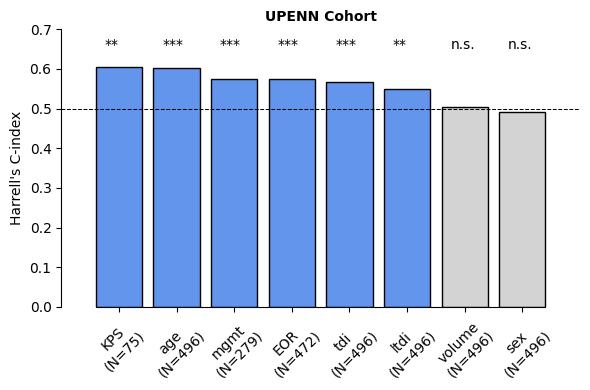

In [27]:
covariates = ["sex", "age", "ltdi", "tdi", "volume", "mgmt", "EOR", "KPS"]
data = DATA[covariates+["OS","status"]]

fig, ax = plt.subplots(1,1, figsize=(6,4))
level_CI = 95
HarrellCindex = np.zeros((len(covariates),))
HarrellCindex_p = np.zeros((len(covariates),))
colors = []
samples = []
for i in range(0,len(covariates)):
    data_notna = data[[covariates[i],"OS","status"]].dropna()
    samples.append(len(data_notna))

    OS_STATS = np.array(
        [(st, ovs) for st, ovs in zip(data_notna["status"].values==1, data_notna["OS"].values)],
        dtype=[('event', 'bool'),('time', 'float')]
    )
    Cmodel = CoxPHSurvivalAnalysis(n_iter=200)
    Cmodel.fit(data_notna[covariates[i]].values.reshape(-1, 1),OS_STATS)
    HarrellCindex[i] = Cmodel.score(data_notna[covariates[i]].values.reshape(-1, 1),OS_STATS)

    # Permutation test for the model without site effect
    pop = []
    for _ in tqdm(range(n_perms), desc=f"Cox feature selection for the covariate {covariates[i]}"):
        perm_OS_STATS = np.random.permutation(OS_STATS)
        p_Cmodel = CoxPHSurvivalAnalysis()
        p_Cmodel.fit(data_notna[covariates[i]].values.reshape(-1, 1),perm_OS_STATS)
        pop.append(p_Cmodel.score(data_notna[covariates[i]].values.reshape(-1, 1),perm_OS_STATS))
    HarrellCindex_p[i] = np.mean(np.array(pop) >= HarrellCindex[i])
    if HarrellCindex_p[i]<=0.001:
        colors.append("cornflowerblue")
    elif HarrellCindex_p[i]<=0.01:
        colors.append("cornflowerblue")
    elif HarrellCindex_p[i]<=0.05:
        colors.append("cornflowerblue")
    else:            
        colors.append("lightgray")
    # Summary
    print(f"Feature: {covariates[i]} with a c-index of {HarrellCindex[i]} (p={HarrellCindex_p[i]})")
ax.bar(
    range(0,len(covariates)), 
    np.sort(HarrellCindex)[::-1],
    edgecolor="black",
    color=[colors[ii] for ii in np.argsort(HarrellCindex)[::-1]]
)
for ii, pval in enumerate(HarrellCindex_p[np.argsort(HarrellCindex)[::-1]]):
    if pval<=0.001:
        ax.text(ii-.25, .65, '***', color='black',fontsize=10, transform=ax.transData)
    elif pval<=0.01:
        ax.text(ii-.25, .65, '**', color='black',fontsize=10, transform=ax.transData)
    elif pval<=0.05:
        ax.text(ii-.25, .65, '*', color='black',fontsize=10, transform=ax.transData)
    else:            
        ax.text(ii-.25, .65, 'n.s.', color='black',fontsize=10, transform=ax.transData)
ax.hlines(0.5, -1, len(covariates), color='black', linewidth=.75, linestyle='--')
ax.spines[["top","right"]].set_visible(False)
ax.set_ylabel("Harrell's C-index")
ax.set_ylim([0,0.7])
ax.set_xlim([-1,len(covariates)])
ax.set_xticks(range(0,len(covariates)))
ax.set_xticklabels([f"{covariates[ii]}\n(N={samples[ii]})" for ii in np.argsort(HarrellCindex)[::-1]], rotation=45)
ax.spines['bottom'].set_bounds(-.4,len(covariates)-.6)
ax.spines['left'].set_bounds(0,.7)
ax.set_title("UPENN Cohort", fontsize=10, fontweight='bold')

fig.tight_layout()
fig.savefig(os.path.join(figs_folder, f"Feature-importance.{fmt}"), dpi=dpi, format=fmt)

### Feature importance

Select K features workflow: 100%|██████████| 50/50 [33:43<00:00, 40.48s/it]


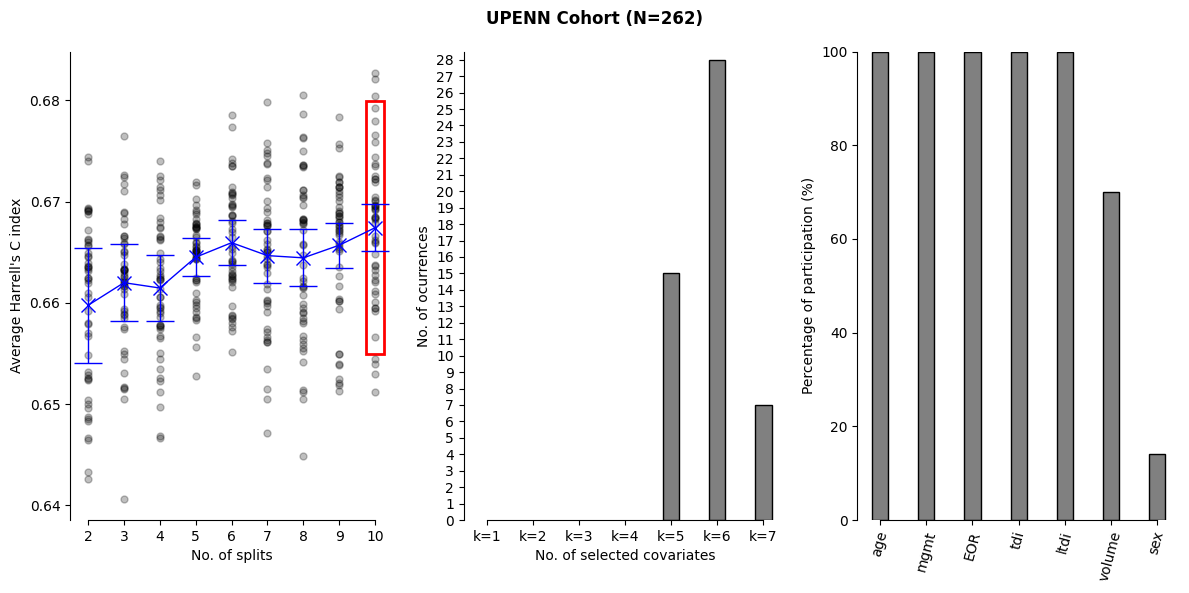

In [28]:
def Harrell_C_index(X, y):
    n_features = X.shape[1]
    Cscores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j : j + 1]
        m.fit(Xj, y)
        Cscores[j] = m.score(Xj, y)
    return Cscores

pipe = Pipeline(
    [
        ("select", SelectKBest(Harrell_C_index)),
        ("model", CoxPHSurvivalAnalysis()),
    ]
)
splits = range(2,11) # 10
runs = 50 # 50

# Features to consider in the order determined by their respective importances (execute cell above)
covariates = ["sex", "age", "ltdi", "tdi", "volume", "mgmt", "EOR", "KPS"]
covariates = [covariates[ii] for ii in np.argsort(HarrellCindex)[::-1]]
covariates.remove("KPS")
data = DATA[covariates+["OS","status"]].dropna()
OS_STATS = np.array([(st, oss) for st,oss in zip(data["status"],data["OS"])], dtype=[('event', 'bool'),('time', '<f4')])
features = data[covariates]

# Feature selection workflow
param_grid = {"select__k": np.arange(1, len(covariates)+1)}
mean_test = np.zeros((runs, len(splits)))
k_best_results = np.zeros((runs, len(splits)))
fig, ax = plt.subplots(1,3, figsize=(12,6))
for tt in tqdm(range(runs), desc=f"Select K features workflow"):
    for i, spl in enumerate(splits):
        cv = KFold(n_splits=spl, shuffle=True, random_state=None) # Assign a given random state if you want to ensure reproducibility
        gcv = GridSearchCV(pipe, param_grid, return_train_score=True, cv=cv)
        gcv.fit(features, OS_STATS)        
        results = pd.DataFrame(gcv.cv_results_).sort_values(by="mean_test_score", ascending=False)
        mean_test[tt,i] = results["mean_test_score"].values.max()
        k_best_results[tt,i] = results["param_select__k"].values[0]
        ax[0].plot(spl, mean_test[tt,i], 'o', color='black', alpha=0.25, markersize=5)


best_split = splits[mean_test.mean(axis=0).argmax()]-2
k_feat, feature_counts = np.unique(k_best_results[:,best_split], return_counts=True)
ax[0].errorbar(splits, mean_test.mean(axis=0), yerr=mean_test.std(axis=0)/np.sqrt(splits), linestyle='-', color='blue', linewidth=1, fmt='x',markersize=10, capsize=10)
rect = patches.Rectangle((best_split+1.75, mean_test.mean(axis=0).max()-.0125), 0.5, 0.025, linewidth=2, edgecolor='r', facecolor='none')
ax[0].add_patch(rect)
ax[0].spines[["top","right"]].set_visible(False)
ax[0].set_xticks(splits)
ax[0].set_xticklabels(splits)
ax[0].set_xlim([splits[0]-.5, splits[-1]+.5])
ax[0].set_xlabel("No. of splits")
ax[0].set_ylabel("Average Harrell's C index")
ax[0].spines['bottom'].set_bounds(splits[0], splits[-1])
ax[1].bar(
    k_feat, 
    feature_counts,
    edgecolor="black",
    color="gray",
    width=.35
)
ax[1].spines[["top","right"]].set_visible(False)
ax[1].set_xlim([.5,features.shape[-1]+.5])
ax[1].set_xticks(range(1,features.shape[-1]+1))
ax[1].set_xticklabels([f"k={ii}" for ii in range(1,features.shape[-1]+1)])
ax[1].set_ylabel("No. of ocurrences")
ax[1].set_xlabel("No. of selected covariates")
ax[1].spines['bottom'].set_bounds(1,features.shape[-1])
ax[1].set_ylim([0, max(feature_counts)+.5])
ax[1].set_yticks(range(0,max(feature_counts)+1))
ax[1].set_yticklabels(range(0,max(feature_counts)+1))
feature_participation = np.zeros((len(covariates),)) # Same order as in labels
for i in range(len(k_feat)):
    k_fs = int(k_feat[i])
    for j in range(k_fs):
        feature_participation[j] += feature_counts[i]

ax[2].bar(
    range(1,features.shape[-1]+1), 
    100*feature_participation/runs,
    edgecolor="black",
    color="gray",
    width=.35
)
ax[2].spines[["top","right"]].set_visible(False)
ax[2].set_xlim([.5,features.shape[-1]+.5])
ax[2].set_xticks(range(1,features.shape[-1]+1))
ax[2].set_xticklabels(covariates, rotation=75)
ax[2].set_ylabel("Percentage of participation (%)")
ax[2].spines['bottom'].set_bounds(1,features.shape[-1])
ax[2].set_ylim([0, 100])
ax[2].set_yticks([0,20,40,60,80,100])
ax[2].set_yticklabels([0,20,40,60,80,100])

fig.suptitle(f"UPENN Cohort (N={len(data)})", fontsize=12, fontweight='bold')
fig.tight_layout()
fig.savefig(os.path.join(figs_folder, f"Feature-selection.{fmt}"), dpi=dpi, format=fmt)

## Missing value strategy &\to& ??

# Logistic regressions

## Death at 6 months

### Including the L-TDI covariate

In [29]:
covariates = ["sex", "age", "ltdi", "mgmt", "EOR"]
data = DATA[covariates+["OS", "status"]].dropna()

## We discard right censoring before the cutoff
cutoff = 6 * daysXmonth
mask_died = (data["OS"]<=cutoff) * (data["status"]==1)
mask_alive = data["OS"]>cutoff
data.loc[:, "died"] = np.where(mask_died, 1, np.where(mask_alive, 0, np.nan))

# Fit the logistic model
data_log = data[covariates+["died"]].dropna()
X = sm.add_constant(data_log[covariates])
logit_model = sm.Logit(data_log["died"], X)
results_log = logit_model.fit()
LR_LTDI_6 = results_log.llf
print(results_log.summary())

Optimization terminated successfully.
         Current function value: 0.486084
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   died   No. Observations:                  262
Model:                          Logit   Df Residuals:                      256
Method:                           MLE   Df Model:                            5
Date:                Tue, 18 Mar 2025   Pseudo R-squ.:                  0.1117
Time:                        17:15:09   Log-Likelihood:                -127.35
converged:                       True   LL-Null:                       -143.36
Covariance Type:            nonrobust   LLR p-value:                 5.906e-06
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.0823      1.227     -2.512      0.012      -5.487      -0.677
sex            0.3025      0.

### Including the TDI covariate

In [30]:
covariates = ["sex", "age", "tdi", "mgmt", "EOR"]
data = DATA[covariates+["OS", "status"]].dropna()

## We discard right censoring before the cutoff
cutoff = 6 * daysXmonth
mask_died = (data["OS"]<=cutoff) * (data["status"]==1)
mask_alive = data["OS"]>cutoff
data.loc[:, "died"] = np.where(mask_died, 1, np.where(mask_alive, 0, np.nan))

# Fit the logistic model
data_log = data[covariates+["died"]].dropna()
X = sm.add_constant(data_log[covariates])
logit_model = sm.Logit(data_log["died"], X)
results_log = logit_model.fit()
LR_TDI_6 = results_log.llf
print(results_log.summary())

Optimization terminated successfully.
         Current function value: 0.480895
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   died   No. Observations:                  262
Model:                          Logit   Df Residuals:                      256
Method:                           MLE   Df Model:                            5
Date:                Tue, 18 Mar 2025   Pseudo R-squ.:                  0.1211
Time:                        17:15:09   Log-Likelihood:                -125.99
converged:                       True   LL-Null:                       -143.36
Covariance Type:            nonrobust   LLR p-value:                 1.702e-06
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.6198      1.296     -2.793      0.005      -6.160      -1.079
sex            0.3026      0.

### Including the TDI and volume as covariates

In [31]:
covariates = ["sex", "age", "tdi", "volume", "mgmt", "EOR"]
data = DATA[covariates+["OS", "status"]].dropna()

## We discard right censoring before the cutoff
cutoff = 6 * daysXmonth
mask_died = (data["OS"]<=cutoff) * (data["status"]==1)
mask_alive = data["OS"]>cutoff
data.loc[:, "died"] = np.where(mask_died, 1, np.where(mask_alive, 0, np.nan))

# Fit the logistic model
data_log = data[covariates+["died"]].dropna()
X = sm.add_constant(data_log[covariates])
logit_model = sm.Logit(data_log["died"], X)
results_log = logit_model.fit()
LR_TDI_volume_6 = results_log.llf
print(results_log.summary())

Optimization terminated successfully.
         Current function value: 0.480367
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   died   No. Observations:                  262
Model:                          Logit   Df Residuals:                      255
Method:                           MLE   Df Model:                            6
Date:                Tue, 18 Mar 2025   Pseudo R-squ.:                  0.1221
Time:                        17:15:09   Log-Likelihood:                -125.86
converged:                       True   LL-Null:                       -143.36
Covariance Type:            nonrobust   LLR p-value:                 4.293e-06
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.4722      1.320     -2.631      0.009      -6.058      -0.886
sex            0.3139      0.

### Excluding tract density-based covariates

In [32]:
covariates = ["sex", "age", "mgmt", "EOR"]
data = DATA[covariates+["OS", "status"]].dropna()

## We discard right censoring before the cutoff
cutoff = 6 * daysXmonth
mask_died = (data["OS"]<=cutoff) * (data["status"]==1)
mask_alive = data["OS"]>cutoff
data.loc[:, "died"] = np.where(mask_died, 1, np.where(mask_alive, 0, np.nan))

# Fit the logistic model
data_log = data[covariates+["died"]].dropna()
X = sm.add_constant(data_log[covariates])
logit_model = sm.Logit(data_log["died"], X)
results_log = logit_model.fit()
LR_without_6 = results_log.llf
print(results_log.summary())

Optimization terminated successfully.
         Current function value: 0.488847
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   died   No. Observations:                  262
Model:                          Logit   Df Residuals:                      257
Method:                           MLE   Df Model:                            4
Date:                Tue, 18 Mar 2025   Pseudo R-squ.:                  0.1066
Time:                        17:15:09   Log-Likelihood:                -128.08
converged:                       True   LL-Null:                       -143.36
Covariance Type:            nonrobust   LLR p-value:                 3.755e-06
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.7064      1.165     -2.322      0.020      -4.991      -0.422
sex            0.3477      0.

## Death at 12 months

### Including the L-TDI covariate

In [33]:
covariates = ["sex", "age", "ltdi", "mgmt", "EOR"]
data = DATA[covariates+["OS", "status"]].dropna()

## We discard right censoring before the cutoff
cutoff = 12 * daysXmonth
mask_died = (data["OS"]<=cutoff) * (data["status"]==1)
mask_alive = data["OS"]>cutoff
data.loc[:, "died"] = np.where(mask_died, 1, np.where(mask_alive, 0, np.nan))

# Fit the logistic model
data_log = data[covariates+["died"]].dropna()
X = sm.add_constant(data_log[covariates])
logit_model = sm.Logit(data_log["died"], X)
results_log = logit_model.fit()
LR_LTDI_12 = results_log.llf
print(results_log.summary())

Optimization terminated successfully.
         Current function value: 0.589297
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                   died   No. Observations:                  262
Model:                          Logit   Df Residuals:                      256
Method:                           MLE   Df Model:                            5
Date:                Tue, 18 Mar 2025   Pseudo R-squ.:                  0.1352
Time:                        17:15:09   Log-Likelihood:                -154.40
converged:                       True   LL-Null:                       -178.54
Covariance Type:            nonrobust   LLR p-value:                 3.104e-09
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2105      1.027     -1.179      0.238      -3.223       0.801
sex            0.0387      0.

### Including the TDI covariate

In [34]:
covariates = ["sex", "age", "tdi", "mgmt", "EOR"]
data = DATA[covariates+["OS", "status"]].dropna()

## We discard right censoring before the cutoff
cutoff = 12 * daysXmonth
mask_died = (data["OS"]<=cutoff) * (data["status"]==1)
mask_alive = data["OS"]>cutoff
data.loc[:, "died"] = np.where(mask_died, 1, np.where(mask_alive, 0, np.nan))

# Fit the logistic model
data_log = data[covariates+["died"]].dropna()
X = sm.add_constant(data_log[covariates])
logit_model = sm.Logit(data_log["died"], X)
results_log = logit_model.fit()
LR_TDI_12 = results_log.llf
print(results_log.summary())

Optimization terminated successfully.
         Current function value: 0.587751
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                   died   No. Observations:                  262
Model:                          Logit   Df Residuals:                      256
Method:                           MLE   Df Model:                            5
Date:                Tue, 18 Mar 2025   Pseudo R-squ.:                  0.1375
Time:                        17:15:09   Log-Likelihood:                -153.99
converged:                       True   LL-Null:                       -178.54
Covariance Type:            nonrobust   LLR p-value:                 2.120e-09
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.5008      1.067     -1.407      0.160      -3.592       0.590
sex            0.0410      0.

### Including the TDI and volume covariates

In [35]:
covariates = ["sex", "age", "tdi", "volume", "mgmt", "EOR"]
data = DATA[covariates+["OS", "status"]].dropna()

## We discard right censoring before the cutoff
cutoff = 12 * daysXmonth
mask_died = (data["OS"]<=cutoff) * (data["status"]==1)
mask_alive = data["OS"]>cutoff
data.loc[:, "died"] = np.where(mask_died, 1, np.where(mask_alive, 0, np.nan))

# Fit the logistic model
data_log = data[covariates+["died"]].dropna()
X = sm.add_constant(data_log[covariates])
logit_model = sm.Logit(data_log["died"], X)
results_log = logit_model.fit()
LR_TDI_volume_12 = results_log.llf
print(results_log.summary())

Optimization terminated successfully.
         Current function value: 0.586495
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                   died   No. Observations:                  262
Model:                          Logit   Df Residuals:                      255
Method:                           MLE   Df Model:                            6
Date:                Tue, 18 Mar 2025   Pseudo R-squ.:                  0.1393
Time:                        17:15:09   Log-Likelihood:                -153.66
converged:                       True   LL-Null:                       -178.54
Covariance Type:            nonrobust   LLR p-value:                 5.264e-09
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6561      1.089     -1.520      0.128      -3.791       0.479
sex            0.0393      0.

### Excluding tract density-based covariates

In [36]:
covariates = ["sex", "age", "mgmt", "EOR"]
data = DATA[covariates+["OS", "status"]].dropna()

## We discard right censoring before the cutoff
cutoff = 12 * daysXmonth
mask_died = (data["OS"]<=cutoff) * (data["status"]==1)
mask_alive = data["OS"]>cutoff
data.loc[:, "died"] = np.where(mask_died, 1, np.where(mask_alive, 0, np.nan))

# Fit the logistic model
data_log = data[covariates+["died"]].dropna()
X = sm.add_constant(data_log[covariates])
logit_model = sm.Logit(data_log["died"], X)
results_log = logit_model.fit()
LR_without_12 = results_log.llf
print(results_log.summary())

Optimization terminated successfully.
         Current function value: 0.600236
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                   died   No. Observations:                  262
Model:                          Logit   Df Residuals:                      257
Method:                           MLE   Df Model:                            4
Date:                Tue, 18 Mar 2025   Pseudo R-squ.:                  0.1192
Time:                        17:15:09   Log-Likelihood:                -157.26
converged:                       True   LL-Null:                       -178.54
Covariance Type:            nonrobust   LLR p-value:                 1.280e-08
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6566      0.973     -0.675      0.500      -2.564       1.250
sex            0.0835      0.

## Death at 18 months

### Including the L-TDI covariate

In [37]:
covariates = ["sex", "age", "ltdi", "mgmt", "EOR"]
data = DATA[covariates+["OS", "status"]].dropna()

## We discard right censoring before the cutoff
cutoff = 18 * daysXmonth
mask_died = (data["OS"]<=cutoff) * (data["status"]==1)
mask_alive = data["OS"]>cutoff
data.loc[:, "died"] = np.where(mask_died, 1, np.where(mask_alive, 0, np.nan))

# Fit the logistic model
data_log = data[covariates+["died"]].dropna()
X = sm.add_constant(data_log[covariates])
logit_model = sm.Logit(data_log["died"], X)
results_log = logit_model.fit()
LR_LTDI_18 = results_log.llf
print(results_log.summary())

Optimization terminated successfully.
         Current function value: 0.556758
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   died   No. Observations:                  262
Model:                          Logit   Df Residuals:                      256
Method:                           MLE   Df Model:                            5
Date:                Tue, 18 Mar 2025   Pseudo R-squ.:                  0.1470
Time:                        17:15:09   Log-Likelihood:                -145.87
converged:                       True   LL-Null:                       -171.01
Covariance Type:            nonrobust   LLR p-value:                 1.214e-09
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7695      1.016      0.757      0.449      -1.222       2.761
sex           -0.1409      0.

### Including the TDI covariate

In [38]:
covariates = ["sex", "age", "tdi", "mgmt", "EOR"]
data = DATA[covariates+["OS", "status"]].dropna() 

## We discard right censoring before the cutoff
cutoff = 18 * daysXmonth
mask_died = (data["OS"]<=cutoff) * (data["status"]==1)
mask_alive = data["OS"]>cutoff
data.loc[:, "died"] = np.where(mask_died, 1, np.where(mask_alive, 0, np.nan))

# Fit the logistic model
data_log = data[covariates+["died"]].dropna()
X = sm.add_constant(data_log[covariates])
logit_model = sm.Logit(data_log["died"], X)
results_log = logit_model.fit()
LR_TDI_18 = results_log.llf
print(results_log.summary())

Optimization terminated successfully.
         Current function value: 0.548668
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   died   No. Observations:                  262
Model:                          Logit   Df Residuals:                      256
Method:                           MLE   Df Model:                            5
Date:                Tue, 18 Mar 2025   Pseudo R-squ.:                  0.1594
Time:                        17:15:09   Log-Likelihood:                -143.75
converged:                       True   LL-Null:                       -171.01
Covariance Type:            nonrobust   LLR p-value:                 1.639e-10
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3929      1.043      0.377      0.706      -1.651       2.436
sex           -0.1885      0.

### Including the TDI and volume covariates

In [39]:
covariates = ["sex", "age", "tdi", "volume", "mgmt", "EOR"]
data = DATA[covariates+["OS", "status"]].dropna()

## We discard right censoring before the cutoff
cutoff = 18 * daysXmonth
mask_died = (data["OS"]<=cutoff) * (data["status"]==1)
mask_alive = data["OS"]>cutoff
data.loc[:, "died"] = np.where(mask_died, 1, np.where(mask_alive, 0, np.nan))

# Fit the logistic model
data_log = data[covariates+["died"]].dropna()
X = sm.add_constant(data_log[covariates])
logit_model = sm.Logit(data_log["died"], X)
results_log = logit_model.fit()
LR_TDI_volume_18 = results_log.llf
print(results_log.summary())

Optimization terminated successfully.
         Current function value: 0.548294
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   died   No. Observations:                  262
Model:                          Logit   Df Residuals:                      255
Method:                           MLE   Df Model:                            6
Date:                Tue, 18 Mar 2025   Pseudo R-squ.:                  0.1600
Time:                        17:15:09   Log-Likelihood:                -143.65
converged:                       True   LL-Null:                       -171.01
Covariance Type:            nonrobust   LLR p-value:                 5.292e-10
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3270      1.054      0.310      0.756      -1.740       2.393
sex           -0.1811      0.

### Excluding tract density-based covariates

In [40]:
covariates = ["sex", "age", "mgmt", "EOR"]
data = DATA[covariates+["OS", "status"]].dropna()

## We discard right censoring before the cutoff
cutoff = 18 * daysXmonth
mask_died = (data["OS"]<=cutoff) * (data["status"]==1)
mask_alive = data["OS"]>cutoff
data.loc[:, "died"] = np.where(mask_died, 1, np.where(mask_alive, 0, np.nan))

# Fit the logistic model
data_log = data[covariates+["died"]].dropna()
X = sm.add_constant(data_log[covariates])
logit_model = sm.Logit(data_log["died"], X)
results_log = logit_model.fit()
LR_without_18 = results_log.llf
print(results_log.summary())

Optimization terminated successfully.
         Current function value: 0.568832
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   died   No. Observations:                  262
Model:                          Logit   Df Residuals:                      257
Method:                           MLE   Df Model:                            4
Date:                Tue, 18 Mar 2025   Pseudo R-squ.:                  0.1285
Time:                        17:15:09   Log-Likelihood:                -149.03
converged:                       True   LL-Null:                       -171.01
Covariance Type:            nonrobust   LLR p-value:                 6.562e-09
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2730      0.988      1.289      0.198      -0.663       3.209
sex           -0.1218      0.

## Comparisson through Log-likelihood ratios

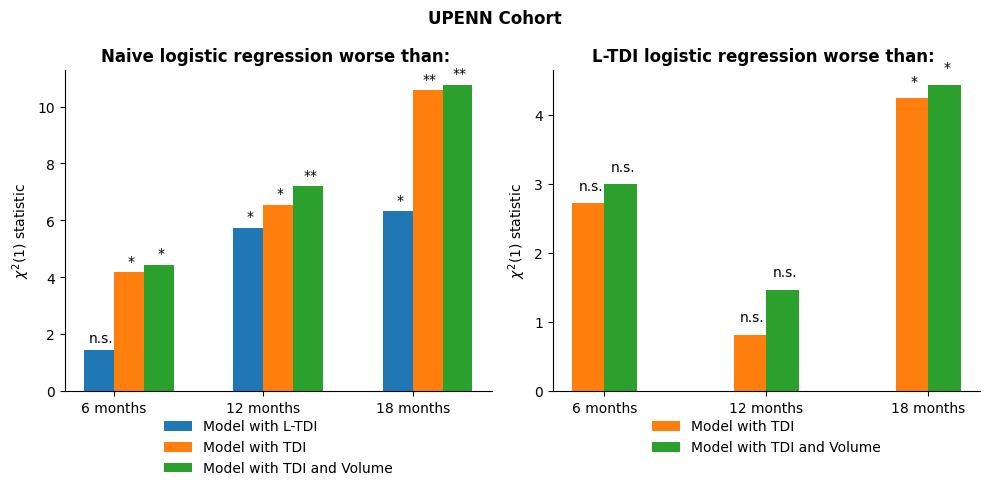

In [41]:
def get_significance_marker(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"  
    elif p < 0.05:
        return "*"  
    else:
        return "n.s." 
    
fig, ax = plt.subplots(1,2,figsize=(10, 5))
bar_width = 0.2
time_labels = ["6 months", "12 months", "18 months"]
x = np.arange(len(time_labels))

### Measuring the added value of tract density-based covariates
model_labels = ["Model with L-TDI", "Model with TDI", "Model with TDI and Volume"]
colors = ["tab:blue", "tab:orange", "tab:green"]
llrs = -2*np.array([
    [LR_LTDI_6-LR_without_6, LR_TDI_6-LR_without_6, LR_TDI_volume_6-LR_without_6],
    [LR_LTDI_12-LR_without_12, LR_TDI_12-LR_without_12, LR_TDI_volume_12-LR_without_12],
    [LR_LTDI_18-LR_without_18, LR_TDI_18-LR_without_18, LR_TDI_volume_18-LR_without_18]
])
llrs = - llrs ## We want to see the increase in LR when adding covariates!!
p_values = 1 - chi2.cdf(llrs, df=1)
for i in range(len(model_labels)):
    bars = ax[0].bar(x + i * bar_width, llrs[:, i], width=bar_width, label=model_labels[i], color=colors[i])
    for j, bar in enumerate(bars):
        height = bar.get_height()
        significance = get_significance_marker(p_values[j, i])
        ax[0].text(
            bar.get_x() + bar.get_width() / 2 + 0.015,
            height + 0.15, 
            significance,
            ha="center", va="bottom", fontsize=10
        )

ax[0].spines[["top","right"]].set_visible(False)
ax[0].set_xticks(x + bar_width/2, time_labels)
ax[0].set_ylabel(r'$\chi^2(1)$'+" statistic")
ax[0].legend(frameon=False, loc="upper center", bbox_to_anchor=(0.5, -0.05))
ax[0].set_title("Naive logistic regression worse than: ", fontweight='bold', fontsize=12)

### L-TDI against the other two models
model_labels = ["Model with TDI", "Model with TDI and Volume"]
colors = ["tab:orange", "tab:green"]
llrs = -2*np.array([
    [LR_TDI_6-LR_LTDI_6, LR_TDI_volume_6-LR_LTDI_6],
    [LR_TDI_12-LR_LTDI_12, LR_TDI_volume_12-LR_LTDI_12],
    [LR_TDI_18-LR_LTDI_18, LR_TDI_volume_18-LR_LTDI_18]
])
llrs = - llrs # Because of the results we test the opposite hypothesis
p_values = 1 - chi2.cdf(llrs, df=1)
for i in range(len(model_labels)):
    bars = ax[1].bar(x + i * bar_width, llrs[:, i], width=bar_width, label=model_labels[i], color=colors[i])
    for j, bar in enumerate(bars):
        height = bar.get_height()
        significance = get_significance_marker(p_values[j, i])
        ax[1].text(
            bar.get_x() + bar.get_width() / 2 + 0.015,  
            height + 0.15,  
            significance,
            ha="center", va="bottom", fontsize=10
        )

ax[1].spines[["top","right"]].set_visible(False)
ax[1].set_xticks(x + bar_width/2, time_labels)
ax[1].set_ylabel(r'$\chi^2(1)$'+" statistic")
ax[1].legend(frameon=False, loc="upper center", bbox_to_anchor=(0.5, -0.05))
ax[1].set_title("L-TDI logistic regression worse than: ", fontweight='bold', fontsize=12)

fig.suptitle(f"UPENN Cohort", fontsize=12, fontweight='bold')
fig.tight_layout()
fig.savefig(os.path.join(figs_folder, f"Logistic-regression.{fmt}"), dpi=dpi, format=fmt)